
# Fit Using Bounds

A major advantage of using lmfit is that one can specify boundaries on fitting
parameters, even if the underlying algorithm in SciPy does not support this.
For more information on how this is implemented, please refer to:
https://lmfit.github.io/lmfit-py/bounds.html

The example below shows how to set boundaries using the ``min`` and ``max``
attributes to fitting parameters.


In [36]:

import numpy as np
from lmfit import Parameters, minimize
from numpy import exp, pi, sign, sin

In [37]:

from paramaterial import DataSet

Define the 'correct' Parameter values and residual function:



In [38]:
p_true = Parameters()
p_true.add('amp', value=14.0)
p_true.add('period', value=5.4321)
p_true.add('shift', value=0.12345)
p_true.add('decay', value=0.01000)


def residual(pars, x, data=None):
    argu = (x*pars['decay'])**2
    shift = pars['shift']
    if abs(shift) > pi/2:
        shift = shift - sign(shift)*pi
    model = pars['amp']*sin(shift + x/pars['period'])*exp(-argu)
    if data is None:
        return model
    return model - data

In [41]:
ds = DataSet('data/02 trimmed small data', 'info/02 trimmed small info.xlsx')
data = ds[0].data
data = data[data['Stress_MPa'] > 50]
data.Strain

35     0.000491
36     0.000538
37     0.000586
38     0.000637
39     0.000684
         ...   
128    0.009218
129    0.009406
130    0.009593
131    0.009780
132    0.009967
Name: Strain, Length: 98, dtype: float64

In [69]:
params = Parameters()
params.add('sig_E', value=230, vary=True, min=100)
params.add('E', value=70e3, vary=True, min=7e4, max=1.4e5)
params.add('C', value=100, vary=True, min=100)
params.add('n', value=1.1, vary=True, min=0.1)


def ramberg(eps, E, sig_E, C, n):
    sig = []
    for e in eps:
        if e <= sig_E/E:
            e_e = e
            e_p = 0
        else:
            e_e = sig_E/E
            e_p = e - e_e
        sig.append(E*e_e + C*(e_p**n))

    return np.array(sig)


def residuals(p, eps):
    return ramberg(eps, p['E'], p['sig_E'], p['C'], p['n']) - data['Strain'].values


out = minimize(residuals, params, args=(data.Stress_MPa,))
report_fit(out)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 98
    # variables        = 4
    chi-square         = 7011644.53
    reduced chi-square = 74591.9631
    Akaike info crit   = 1103.45530
    Bayesian info crit = 1113.79517
##  Warning: uncertainties could not be estimated:
    sig_E:  at boundary
    E:      at initial value
    E:      at boundary
    C:      at initial value
    C:      at boundary
[[Variables]]
    sig_E:  100.000000 (init = 230)
    E:      70000.0004 (init = 70000)
    C:      100.000000 (init = 100)
    n:      0.10002877 (init = 1.1)


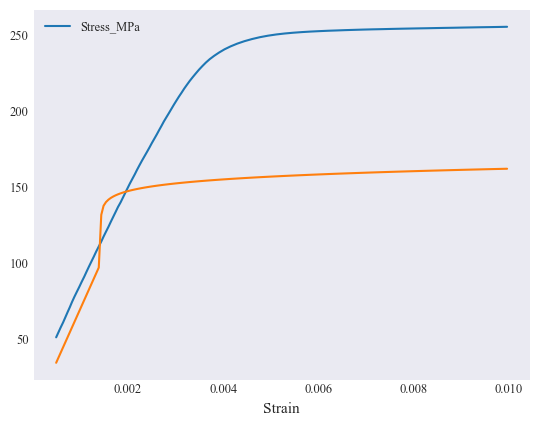

In [70]:
fit = ramberg(data.Strain, **out.params)
ax = data.plot(x='Strain', y='Stress_MPa')
ax.plot(data.Strain, fit)